# Swithching Power

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from halfBridgeModule import detectCommutation, switchingLosesHalfBridge

In [2]:
labels = {'i_out': 'Three Phase Inverter1.IGBT Leg1.il',
          'sw': 'Three Phase Inverter1.IGBT Leg1.PWM_Modulator_TOP_1'}

df_carrier_based = pd.read_pickle('../output/carrier_based.pklcap')
df_sinusoidal = pd.read_pickle('../output/sinusoidal.pklcap')
df_svm = pd.read_pickle('../output/svm.pklcap')

df_mods = {'carrier_based': df_carrier_based,
           'sinusoidal': df_sinusoidal,
           'svm': df_svm}

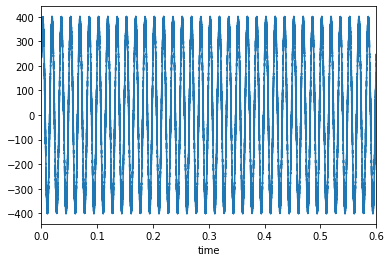

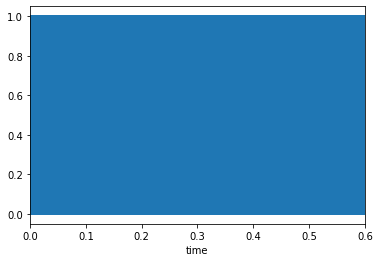

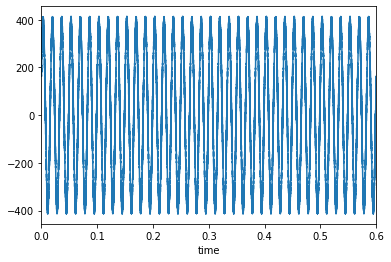

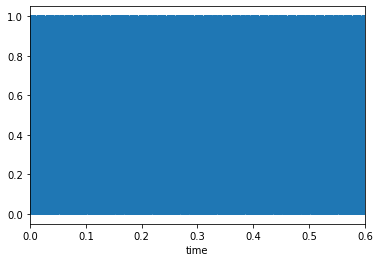

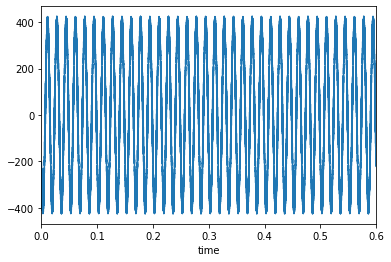

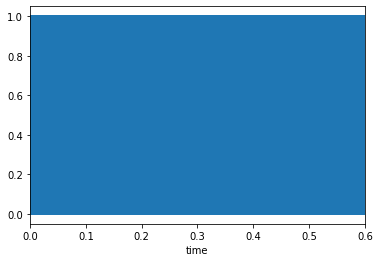

In [3]:
for df_mod_k in df_mods:
    df_mods[df_mod_k][labels['i_out']].plot()
    plt.show()
    df_mods[df_mod_k][labels['sw']].plot()
    plt.show()

## Importando os modelos

In [4]:
import pickle

with open('models/SKM400GB125D.pklmod', 'rb') as filep:
    IGBT_model = pickle.load(filep)

with open('models/SKM350MB120SCH17.pklmod', 'rb') as filep:
    SiC_model = pickle.load(filep)

In [5]:
models = {'IGBT': IGBT_model, 'SiC': SiC_model}

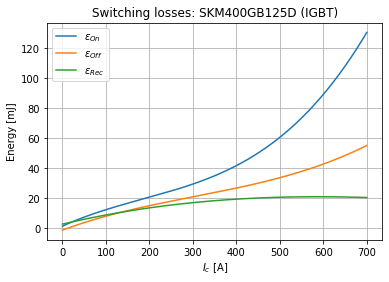

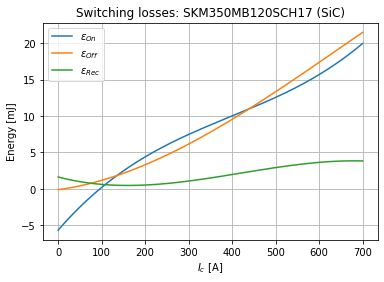

In [6]:
for model in models.values():
    name = model['name']
    type_ = model['type']
    
    p_eon = model['eon']
    p_eoff = model['eoff']
    p_erec = model['erec']
    
    i = np.linspace(0, 700, 200)

    eon  = p_eon(i)
    eoff = p_eoff(i)
    erec = p_erec(i)
#     eDon = p_eDon(i)

    plt.plot(i, eon*1e3, label='$\epsilon_{On}$')
    plt.plot(i, eoff*1e3, label='$\epsilon_{Off}$')
    plt.plot(i, erec*1e3, label='$\epsilon_{Rec}$')
#     plt.plot(i, eDon*1e3, label='Poly D On')
    plt.title('Switching losses: %s (%s)' % (name, type_)) 
    plt.xlabel('$I_c$ [A]') 
    plt.ylabel('Energy [mJ]')
    plt.grid()
    plt.legend()
    plt.show()

In [13]:
switching_results_order = []
switching_results = []

for df_mod_k in df_mods:
    df_mod = df_mods[df_mod_k]
    
    time = df_mod.index
    Iout = df_mod[labels['i_out']]
    pwm_s1 = df_mod[labels['sw']]
    for model_k in models:
        model = models[model_k]
        
        p_eon = model['eon']
        p_eoff = model['eoff']
        p_erec = model['erec']

        P_sw = switchingLosesHalfBridge(pwm_s1, Iout, time[-1] - time[0], p_eon, p_eoff, p_erec, None, verbate=False)
        switching_results.append(P_sw)
        switching_results_order.append((df_mod_k, model_k))

## Resultado Final das potências dissipadas de cada um dos semicondutores $S_1$, $S_2$, $D_1$ e $D_2$ , em Watts

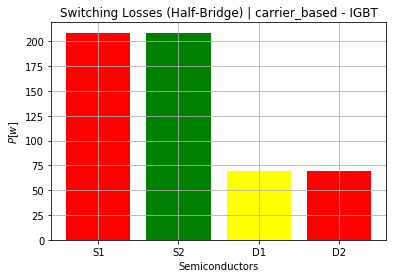

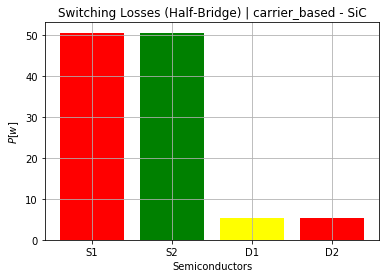

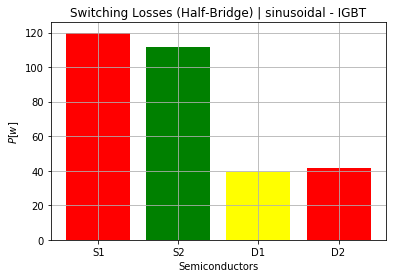

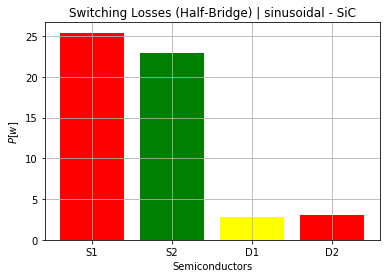

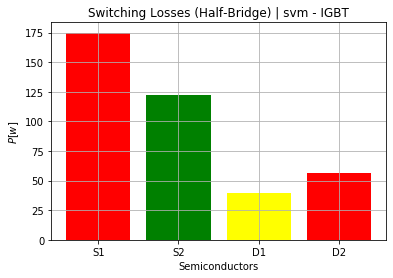

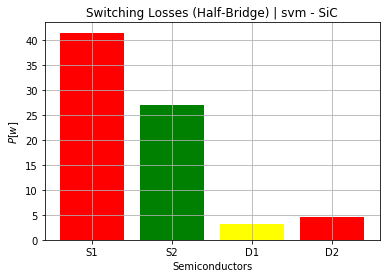

In [16]:
for name, P_sw in zip(switching_results_order, switching_results):
    x = np.arange(4)
    plt.bar(x, P_sw.values(), color =['red', 'green', 'yellow'])
    plt.xticks(x, P_sw.keys())
    plt.ylabel('$P [w]$')
    plt.xlabel('Semiconductors')
    plt.grid()
    plt.title('Switching Losses (Half-Bridge) | %s - %s' % (name))
    plt.show()

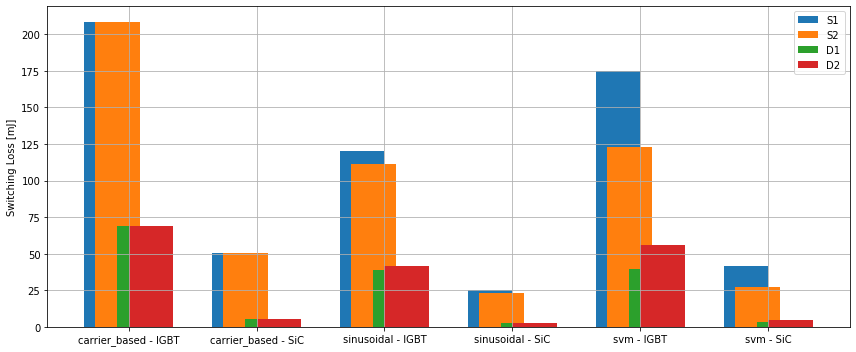

In [28]:
labels = ['%s - %s' % (mod, cmp) for mod, cmp in switching_results_order]
S1 = [P_sw['S1']for P_sw in switching_results]
S2 = [P_sw['S2']for P_sw in switching_results]
D1 = [P_sw['D1']for P_sw in switching_results]
D2 = [P_sw['D2']for P_sw in switching_results]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 5))
rects1 = ax.bar(x - width/2, S1, width, label='S1')
rects2 = ax.bar(x - width/4, S2, width, label='S2')
rects3 = ax.bar(x + width/4, D1, width, label='D1')
rects4 = ax.bar(x + width/2, D2, width, label='D2')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Switching Loss [mJ]')
# ax.set_title('Scores by group and gender')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


# autolabel(rects1)
# autolabel(rects2)
# autolabel(rects3)
# autolabel(rects4)

fig.tight_layout()
plt.grid()
plt.show()